# First: load imports needed for the project and preparation of the project

In [1]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 167 (delta 103), reused 26 (delta 12), pack-reused 0
Receiving objects: 100% (167/167), 3.69 MiB | 5.87 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/Bsc_Thesis
/content


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import math
from torch import Tensor, float32, sin, cos
import torch.nn as nn
import matplotlib.pyplot as plt
import utils_bsc
import datetime
import statistics
import seaborn as sns
from tqdm import tqdm

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla T4


In [3]:
utils_bsc.print_versions()

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.5
PyTorch: 1.10.0+cu111
Sklearn: 1.0.2
seaborn: 0.11.2


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [4]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the previous value).

In [5]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [6]:
print_data = False

if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [7]:
# Set to True to print the graphs

print_graphs = False

if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [8]:
# We print some graphs showing the density distribution of every feature

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [9]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [10]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [11]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very dofferent. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [32]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_scaled = df.copy()
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_scaled.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [34]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 819.95it/s]


In [35]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1189.55it/s]


In [36]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1071.62it/s]


In [37]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [38]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [39]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

# Preparation Training and Test set

Once the dataset is prepared, make batches of data,put them togheter in an array and split them into train and test sets.
After looking through the dataset and the features, i decided to takeonly the values with a timestap of a weekday between 4:00 and 19:30. In many of the features in the interval outside those timestamps there i only noise, which can be a sign that the machine is off in that time interval.

In [54]:
batches_whole = utils_bsc.create_batches(dataset_clean, 30)
batches_whole_norm = utils_bsc.create_batches(dataset_norm, 30)

print(f'\nWhole dataset: {len(batches_whole)} pairs of sequences of longitud {batches_whole[0].shape[1]} with {batches_whole[0].shape[2]} features')
print(f'Whole dataset Normalised: {len(batches_whole_norm)} pairs of sequences of longitud {batches_whole_norm[0].shape[1]} with {batches_whole_norm[0].shape[2]} features')


100%|██████████| 63330/63330 [00:10<00:00, 6049.84it/s]


(63329, 2, 30, 18)

Whole dataset: 63329 pairs of sequences of longitud 30 with 18 features
Whole dataset Normalised: 63329 pairs of sequences of longitud 30 with 18 features


In [104]:
print(batches_whole_norm.shape)
print(type(batches_whole_norm))
print(type(batches_whole_norm[0]))
print(type(batches_whole_norm[0][0][0]))
for i in batches_whole_norm[0][0][0]:
  print(type(i))

(63329, 2, 30, 18)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [119]:
# Spliting into train and test sets and convert into pytorch tensors with the normalised data


training_data_whole_norm, testing_data_whole_norm = train_test_split(batches_whole_norm, test_size=0.1, random_state=25)

print(type(training_data_whole_norm))
print(training_data_whole_norm.shape)
print(type(training_data_whole_norm[0]))
print(training_data_whole_norm[0].shape)
print(type(training_data_whole_norm[0][0]))
print(training_data_whole_norm[0][0].shape)
print(type(training_data_whole_norm[0][0][0]))
print(training_data_whole_norm[0][0][0].shape)
print(training_data_whole_norm[0][0][0])

training_data_whole_norm = torch.from_numpy(training_data_whole_norm).float().to(device)
testing_data_whole_norm = torch.from_numpy(testing_data_whole_norm).float().to(device)

print(f'length of training set (whole dataset): {training_data_whole.shape[0]}')
print(f'length of test set (whole dataset): {testing_data_whole.shape[0]}')
print('\n')

<class 'numpy.ndarray'>
(56996, 2, 30, 18)
<class 'numpy.ndarray'>
(2, 30, 18)
<class 'numpy.ndarray'>
(30, 18)
<class 'numpy.ndarray'>
(18,)
[ 0.93692739  0.66488652  0.73407013 -1.02309578 -0.94027917 -1.06852472
  0.84702147  0.65598575  0.80809456  1.20410812  0.67898539 -0.08118725
 -0.25362287 -0.3452846  -0.46933621  0.05300223 -0.15610002 -0.51219082]


NameError: ignored

In [154]:
def create_dataloaders(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
  # When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) -1)):
    data = np.array([j for j in dataset_norm.iloc[i, 1:]])
    target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=64,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=64,
      shuffle=True
  )

  return loader_train, loader_test

100%|██████████| 63359/63359 [00:24<00:00, 2597.55it/s]


In [155]:
loader_train, loader_test = create_dataloaders(dataset_norm)

length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [174]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.4737895984206804
Standard deviation Loss of baselinemodel:  0.0921930851126969


Test set
Mean Loss of baselinemodel:  0.4659305726638948
Standard deviation Loss of baselinemodel:  0.08732699834948955




# Train a simple Feed Forward Neural Network

I trained a simple FFN Network to have a second baseline model. The final model training should have also a better performance than this FFN.

In [199]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 360)
        self.linear3 = nn.Linear(360, 360)
        self.linear4 = nn.Linear(360, 180)
        self.linear5 = nn.Linear(180, D_out)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.relu(self.linear3(x))
        x = torch.relu(self.linear4(x))
        return self.linear5(x)

# This function trains the model for one epoch
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs):

    epoch_loss_train = []
    epoch_loss_test = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      print('Train')
      model.train()

      for i in tqdm(train_loader):

        data, target = i[0], i[1]

        optimizer.zero_grad()

        # Forward Pass
        output = model(data)

        #Compute loss
        loss = criterion(output, target)

        #Backpropagation
        loss.backward()

        #Optimization
        optimizer.step()

      losses = []

      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(train_loader):

          data, target = i[0], i[1]

          output = model(data)
              
          losses.append (float(criterion(output, target).item()))

      print('\nCurrent Mean loss Train: ', np.mean(losses))
      epoch_loss_train.append(losses)

      losses = []

      print('\nTest with test set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(test_loader):

          data, target = i[0], i[1]

          output = model(data)
            
          losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss_test.append(losses)

    return model, epoch_loss_train, epoch_loss_test

In [200]:
n_epochs = 100
lr=0.01

# Create model FFN instance
model_FFN = ANN_relu(18, 18).to(device)
print(model_FFN)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer = torch.optim.SGD(model_FFN.parameters(), lr=lr)


train_FFN = True
if train_FFN is True:
  trained_model_FFN , train_losses, test_losses = train(model_FFN, criterion, optimizer, loader_train, loader_test, n_epochs)


ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=360, bias=True)
  (linear3): Linear(in_features=360, out_features=360, bias=True)
  (linear4): Linear(in_features=360, out_features=180, bias=True)
  (linear5): Linear(in_features=180, out_features=18, bias=True)
)

Epoch 1:
Train


100%|██████████| 891/891 [00:01<00:00, 479.25it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 950.35it/s]



Current Mean loss Train:  0.5068693360027373

Test with test set


100%|██████████| 99/99 [00:00<00:00, 946.57it/s]



Current Mean loss:  0.4999030933837698

Epoch 2:
Train


100%|██████████| 891/891 [00:01<00:00, 478.97it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 952.86it/s]



Current Mean loss Train:  0.4569430349250434

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1006.06it/s]



Current Mean loss:  0.44941506903580947

Epoch 3:
Train


100%|██████████| 891/891 [00:01<00:00, 483.43it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 953.11it/s]



Current Mean loss Train:  0.3967737156467138

Test with test set


100%|██████████| 99/99 [00:00<00:00, 985.98it/s]



Current Mean loss:  0.3889417311157843

Epoch 4:
Train


100%|██████████| 891/891 [00:01<00:00, 481.14it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 952.87it/s]



Current Mean loss Train:  0.3698858347806064

Test with test set


100%|██████████| 99/99 [00:00<00:00, 951.54it/s]



Current Mean loss:  0.3614835227378691

Epoch 5:
Train


100%|██████████| 891/891 [00:01<00:00, 472.08it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 947.29it/s]



Current Mean loss Train:  0.3495576353921366

Test with test set


100%|██████████| 99/99 [00:00<00:00, 896.38it/s]



Current Mean loss:  0.3413924835246019

Epoch 6:
Train


100%|██████████| 891/891 [00:01<00:00, 486.49it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 960.40it/s]



Current Mean loss Train:  0.33325558743626715

Test with test set


100%|██████████| 99/99 [00:00<00:00, 890.52it/s]



Current Mean loss:  0.3252455888673513

Epoch 7:
Train


100%|██████████| 891/891 [00:01<00:00, 476.60it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 963.25it/s]



Current Mean loss Train:  0.3262156714360187

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1004.00it/s]



Current Mean loss:  0.3183973538454133

Epoch 8:
Train


100%|██████████| 891/891 [00:01<00:00, 475.10it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 969.69it/s]



Current Mean loss Train:  0.3212228625778665

Test with test set


100%|██████████| 99/99 [00:00<00:00, 918.65it/s]



Current Mean loss:  0.3136124028400941

Epoch 9:
Train


100%|██████████| 891/891 [00:01<00:00, 472.44it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 954.84it/s]



Current Mean loss Train:  0.3169801404613972

Test with test set


100%|██████████| 99/99 [00:00<00:00, 905.87it/s]



Current Mean loss:  0.3096980777653781

Epoch 10:
Train


100%|██████████| 891/891 [00:01<00:00, 481.37it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 938.91it/s]



Current Mean loss Train:  0.31284711708123436

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1033.86it/s]



Current Mean loss:  0.3050726805672501

Epoch 11:
Train


100%|██████████| 891/891 [00:01<00:00, 480.21it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 949.22it/s]



Current Mean loss Train:  0.30933652898478586

Test with test set


100%|██████████| 99/99 [00:00<00:00, 912.40it/s]



Current Mean loss:  0.30150272975666353

Epoch 12:
Train


100%|██████████| 891/891 [00:01<00:00, 474.23it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 953.39it/s]



Current Mean loss Train:  0.30686406429969904

Test with test set


100%|██████████| 99/99 [00:00<00:00, 908.27it/s]



Current Mean loss:  0.2991629661333681

Epoch 13:
Train


100%|██████████| 891/891 [00:01<00:00, 471.50it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 915.57it/s]



Current Mean loss Train:  0.305249529538465

Test with test set


100%|██████████| 99/99 [00:00<00:00, 790.04it/s]



Current Mean loss:  0.2979123076104154

Epoch 14:
Train


100%|██████████| 891/891 [00:02<00:00, 412.36it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 956.57it/s]



Current Mean loss Train:  0.3039183975704324

Test with test set


100%|██████████| 99/99 [00:00<00:00, 928.61it/s]



Current Mean loss:  0.2964372695094407

Epoch 15:
Train


100%|██████████| 891/891 [00:02<00:00, 379.81it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 900.36it/s]



Current Mean loss Train:  0.30324338542090523

Test with test set


100%|██████████| 99/99 [00:00<00:00, 897.31it/s]



Current Mean loss:  0.29572054382526514

Epoch 16:
Train


100%|██████████| 891/891 [00:02<00:00, 385.67it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 908.57it/s]



Current Mean loss Train:  0.3027397803251457

Test with test set


100%|██████████| 99/99 [00:00<00:00, 883.44it/s]



Current Mean loss:  0.29535617716986723

Epoch 17:
Train


100%|██████████| 891/891 [00:02<00:00, 307.50it/s]



Test with training set


100%|██████████| 891/891 [00:01<00:00, 795.50it/s]



Current Mean loss Train:  0.30221576209354617

Test with test set


100%|██████████| 99/99 [00:00<00:00, 913.49it/s]



Current Mean loss:  0.29491464372235116

Epoch 18:
Train


100%|██████████| 891/891 [00:01<00:00, 476.09it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 953.42it/s]



Current Mean loss Train:  0.30167338288860557

Test with test set


100%|██████████| 99/99 [00:00<00:00, 924.76it/s]



Current Mean loss:  0.2943750919416697

Epoch 19:
Train


100%|██████████| 891/891 [00:01<00:00, 475.04it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 954.74it/s]



Current Mean loss Train:  0.30142547439378253

Test with test set


100%|██████████| 99/99 [00:00<00:00, 902.98it/s]



Current Mean loss:  0.2941768119732539

Epoch 20:
Train


100%|██████████| 891/891 [00:01<00:00, 480.91it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 964.88it/s]



Current Mean loss Train:  0.3009402551400809

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1021.50it/s]



Current Mean loss:  0.2934046491529002

Epoch 21:
Train


100%|██████████| 891/891 [00:01<00:00, 493.62it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 948.79it/s]



Current Mean loss Train:  0.30048474840042166

Test with test set


100%|██████████| 99/99 [00:00<00:00, 938.90it/s]



Current Mean loss:  0.2930871427360207

Epoch 22:
Train


100%|██████████| 891/891 [00:01<00:00, 476.33it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 936.30it/s]



Current Mean loss Train:  0.30035269124941394

Test with test set


100%|██████████| 99/99 [00:00<00:00, 858.81it/s]



Current Mean loss:  0.2933030268459609

Epoch 23:
Train


100%|██████████| 891/891 [00:02<00:00, 419.04it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 906.65it/s]



Current Mean loss Train:  0.3009291704990781

Test with test set


100%|██████████| 99/99 [00:00<00:00, 855.36it/s]



Current Mean loss:  0.29284106405696486

Epoch 24:
Train


100%|██████████| 891/891 [00:02<00:00, 412.18it/s]



Test with training set


100%|██████████| 891/891 [00:01<00:00, 796.17it/s]



Current Mean loss Train:  0.29972083211012024

Test with test set


100%|██████████| 99/99 [00:00<00:00, 900.42it/s]



Current Mean loss:  0.2923550453751978

Epoch 25:
Train


100%|██████████| 891/891 [00:02<00:00, 373.13it/s]



Test with training set


100%|██████████| 891/891 [00:01<00:00, 818.26it/s]



Current Mean loss Train:  0.2994864912145467

Test with test set


100%|██████████| 99/99 [00:00<00:00, 820.56it/s]



Current Mean loss:  0.2924706559590619

Epoch 26:
Train


100%|██████████| 891/891 [00:02<00:00, 329.37it/s]



Test with training set


100%|██████████| 891/891 [00:01<00:00, 888.48it/s]



Current Mean loss Train:  0.29900513507434145

Test with test set


100%|██████████| 99/99 [00:00<00:00, 857.41it/s]



Current Mean loss:  0.2916701702457486

Epoch 27:
Train


100%|██████████| 891/891 [00:02<00:00, 400.67it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 954.18it/s]



Current Mean loss Train:  0.29861731425880983

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1018.10it/s]



Current Mean loss:  0.29136594272021094

Epoch 28:
Train


100%|██████████| 891/891 [00:01<00:00, 470.46it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 940.31it/s]



Current Mean loss Train:  0.2983710637063156

Test with test set


100%|██████████| 99/99 [00:00<00:00, 916.16it/s]



Current Mean loss:  0.29117506321030434

Epoch 29:
Train


100%|██████████| 891/891 [00:01<00:00, 478.39it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 944.24it/s]



Current Mean loss Train:  0.2982997006907072

Test with test set


100%|██████████| 99/99 [00:00<00:00, 910.53it/s]



Current Mean loss:  0.29128233140165155

Epoch 30:
Train


100%|██████████| 891/891 [00:02<00:00, 444.76it/s]



Test with training set


100%|██████████| 891/891 [00:01<00:00, 877.63it/s]



Current Mean loss Train:  0.2988666404711812

Test with test set


100%|██████████| 99/99 [00:00<00:00, 902.91it/s]



Current Mean loss:  0.29240566522184047

Epoch 31:
Train


100%|██████████| 891/891 [00:01<00:00, 479.82it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 947.21it/s]



Current Mean loss Train:  0.29773308595958115

Test with test set


100%|██████████| 99/99 [00:00<00:00, 921.38it/s]



Current Mean loss:  0.2905080792578784

Epoch 32:
Train


100%|██████████| 891/891 [00:01<00:00, 466.53it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 938.96it/s]



Current Mean loss Train:  0.29747065679325935

Test with test set


100%|██████████| 99/99 [00:00<00:00, 848.55it/s]



Current Mean loss:  0.2905989191447846

Epoch 33:
Train


100%|██████████| 891/891 [00:02<00:00, 396.70it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 945.26it/s]



Current Mean loss Train:  0.2973584412491549

Test with test set


100%|██████████| 99/99 [00:00<00:00, 911.02it/s]



Current Mean loss:  0.29054668666136385

Epoch 34:
Train


100%|██████████| 891/891 [00:01<00:00, 452.50it/s]



Test with training set


100%|██████████| 891/891 [00:01<00:00, 825.49it/s]



Current Mean loss Train:  0.297015551348059

Test with test set


100%|██████████| 99/99 [00:00<00:00, 825.82it/s]



Current Mean loss:  0.2899420914625881

Epoch 35:
Train


100%|██████████| 891/891 [00:02<00:00, 402.65it/s]



Test with training set


100%|██████████| 891/891 [00:01<00:00, 864.99it/s]



Current Mean loss Train:  0.29797958503200284

Test with test set


100%|██████████| 99/99 [00:00<00:00, 886.10it/s]



Current Mean loss:  0.290186208908004

Epoch 36:
Train


100%|██████████| 891/891 [00:01<00:00, 450.01it/s]



Test with training set


100%|██████████| 891/891 [00:01<00:00, 848.89it/s]



Current Mean loss Train:  0.2967418217665686

Test with test set


100%|██████████| 99/99 [00:00<00:00, 848.02it/s]



Current Mean loss:  0.2900303481805204

Epoch 37:
Train


100%|██████████| 891/891 [00:02<00:00, 330.58it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 896.71it/s]



Current Mean loss Train:  0.29689069216031955

Test with test set


100%|██████████| 99/99 [00:00<00:00, 769.11it/s]



Current Mean loss:  0.2903178513351113

Epoch 38:
Train


100%|██████████| 891/891 [00:02<00:00, 391.27it/s]



Test with training set


100%|██████████| 891/891 [00:01<00:00, 645.35it/s]



Current Mean loss Train:  0.2962459004186219

Test with test set


100%|██████████| 99/99 [00:00<00:00, 544.59it/s]



Current Mean loss:  0.2894832798928926

Epoch 39:
Train


100%|██████████| 891/891 [00:02<00:00, 410.75it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 957.77it/s]



Current Mean loss Train:  0.2959375299521702

Test with test set


100%|██████████| 99/99 [00:00<00:00, 906.08it/s]



Current Mean loss:  0.2891097991454481

Epoch 40:
Train


100%|██████████| 891/891 [00:01<00:00, 472.68it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 943.44it/s]



Current Mean loss Train:  0.29599097588514506

Test with test set


100%|██████████| 99/99 [00:00<00:00, 916.80it/s]



Current Mean loss:  0.28929723979848804

Epoch 41:
Train


100%|██████████| 891/891 [00:01<00:00, 478.58it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 938.86it/s]



Current Mean loss Train:  0.29593547957914845

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1022.77it/s]



Current Mean loss:  0.2887855927751522

Epoch 42:
Train


100%|██████████| 891/891 [00:01<00:00, 483.61it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 945.74it/s]



Current Mean loss Train:  0.29579139254176123

Test with test set


100%|██████████| 99/99 [00:00<00:00, 919.61it/s]



Current Mean loss:  0.2894095358523456

Epoch 43:
Train


100%|██████████| 891/891 [00:01<00:00, 475.66it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 948.82it/s]



Current Mean loss Train:  0.29537946151362526

Test with test set


100%|██████████| 99/99 [00:00<00:00, 900.32it/s]



Current Mean loss:  0.2883235497607125

Epoch 44:
Train


100%|██████████| 891/891 [00:01<00:00, 469.26it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 952.96it/s]



Current Mean loss Train:  0.29505307333571074

Test with test set


100%|██████████| 99/99 [00:00<00:00, 835.85it/s]



Current Mean loss:  0.2881298352672596

Epoch 45:
Train


100%|██████████| 891/891 [00:01<00:00, 479.64it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 945.95it/s]



Current Mean loss Train:  0.2949834183008984

Test with test set


100%|██████████| 99/99 [00:00<00:00, 926.91it/s]



Current Mean loss:  0.2881025110531335

Epoch 46:
Train


100%|██████████| 891/891 [00:01<00:00, 471.30it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 958.99it/s]



Current Mean loss Train:  0.29508838574292284

Test with test set


100%|██████████| 99/99 [00:00<00:00, 951.23it/s]



Current Mean loss:  0.2879295797661097

Epoch 47:
Train


100%|██████████| 891/891 [00:01<00:00, 478.62it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 946.91it/s]



Current Mean loss Train:  0.29460796377674897

Test with test set


100%|██████████| 99/99 [00:00<00:00, 920.45it/s]



Current Mean loss:  0.2879130805682654

Epoch 48:
Train


100%|██████████| 891/891 [00:01<00:00, 460.83it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 932.58it/s]



Current Mean loss Train:  0.29478862160852326

Test with test set


100%|██████████| 99/99 [00:00<00:00, 906.73it/s]



Current Mean loss:  0.2884436281341495

Epoch 49:
Train


100%|██████████| 891/891 [00:01<00:00, 481.35it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 962.09it/s]



Current Mean loss Train:  0.2944917155536337

Test with test set


100%|██████████| 99/99 [00:00<00:00, 896.06it/s]



Current Mean loss:  0.2875738366685732

Epoch 50:
Train


100%|██████████| 891/891 [00:01<00:00, 463.98it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 946.62it/s]



Current Mean loss Train:  0.2942438774504913

Test with test set


100%|██████████| 99/99 [00:00<00:00, 878.37it/s]



Current Mean loss:  0.28781707630012976

Epoch 51:
Train


100%|██████████| 891/891 [00:01<00:00, 460.05it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 945.19it/s]



Current Mean loss Train:  0.2960587162796228

Test with test set


100%|██████████| 99/99 [00:00<00:00, 887.02it/s]



Current Mean loss:  0.2885262082622509

Epoch 52:
Train


100%|██████████| 891/891 [00:01<00:00, 459.55it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 941.45it/s]



Current Mean loss Train:  0.29466987460617533

Test with test set


100%|██████████| 99/99 [00:00<00:00, 888.74it/s]



Current Mean loss:  0.2875301025130532

Epoch 53:
Train


100%|██████████| 891/891 [00:01<00:00, 465.20it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 939.53it/s]



Current Mean loss Train:  0.29404417073352035

Test with test set


100%|██████████| 99/99 [00:00<00:00, 923.11it/s]



Current Mean loss:  0.28717569103746704

Epoch 54:
Train


100%|██████████| 891/891 [00:01<00:00, 470.07it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1001.17it/s]



Current Mean loss Train:  0.293790703336264

Test with test set


100%|██████████| 99/99 [00:00<00:00, 921.43it/s]



Current Mean loss:  0.28708791431754527

Epoch 55:
Train


100%|██████████| 891/891 [00:01<00:00, 465.74it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 941.67it/s]



Current Mean loss Train:  0.2935881776741458

Test with test set


100%|██████████| 99/99 [00:00<00:00, 896.63it/s]



Current Mean loss:  0.28719604512055713

Epoch 56:
Train


100%|██████████| 891/891 [00:01<00:00, 476.09it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 938.24it/s]



Current Mean loss Train:  0.2936988437650715

Test with test set


100%|██████████| 99/99 [00:00<00:00, 880.17it/s]



Current Mean loss:  0.2876783072045355

Epoch 57:
Train


100%|██████████| 891/891 [00:01<00:00, 474.55it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 942.80it/s]



Current Mean loss Train:  0.2939910999887051

Test with test set


100%|██████████| 99/99 [00:00<00:00, 873.63it/s]



Current Mean loss:  0.2870119179439063

Epoch 58:
Train


100%|██████████| 891/891 [00:01<00:00, 469.10it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 974.03it/s]



Current Mean loss Train:  0.2932385092665986

Test with test set


100%|██████████| 99/99 [00:00<00:00, 876.46it/s]



Current Mean loss:  0.2867358936504884

Epoch 59:
Train


100%|██████████| 891/891 [00:01<00:00, 473.48it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 946.58it/s]



Current Mean loss Train:  0.2929927287445593

Test with test set


100%|██████████| 99/99 [00:00<00:00, 904.24it/s]



Current Mean loss:  0.28657879341732373

Epoch 60:
Train


100%|██████████| 891/891 [00:01<00:00, 475.22it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 945.82it/s]



Current Mean loss Train:  0.29293752387249644

Test with test set


100%|██████████| 99/99 [00:00<00:00, 912.49it/s]



Current Mean loss:  0.2868418205868114

Epoch 61:
Train


100%|██████████| 891/891 [00:01<00:00, 462.36it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 948.29it/s]



Current Mean loss Train:  0.29277553435260334

Test with test set


100%|██████████| 99/99 [00:00<00:00, 917.55it/s]



Current Mean loss:  0.2866078875582628

Epoch 62:
Train


100%|██████████| 891/891 [00:01<00:00, 472.16it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 959.09it/s]



Current Mean loss Train:  0.292839834836597

Test with test set


100%|██████████| 99/99 [00:00<00:00, 934.82it/s]



Current Mean loss:  0.2862466030349635

Epoch 63:
Train


100%|██████████| 891/891 [00:01<00:00, 467.44it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 963.03it/s]



Current Mean loss Train:  0.2928473061885095

Test with test set


100%|██████████| 99/99 [00:00<00:00, 914.70it/s]



Current Mean loss:  0.2869372647820097

Epoch 64:
Train


100%|██████████| 891/891 [00:01<00:00, 467.72it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 953.25it/s]



Current Mean loss Train:  0.2926027997408384

Test with test set


100%|██████████| 99/99 [00:00<00:00, 874.41it/s]



Current Mean loss:  0.2858579575714439

Epoch 65:
Train


100%|██████████| 891/891 [00:01<00:00, 466.67it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 932.13it/s]



Current Mean loss Train:  0.2924849922307814

Test with test set


100%|██████████| 99/99 [00:00<00:00, 874.21it/s]



Current Mean loss:  0.28637050573874

Epoch 66:
Train


100%|██████████| 891/891 [00:01<00:00, 463.44it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 935.20it/s]



Current Mean loss Train:  0.2923819849687795

Test with test set


100%|██████████| 99/99 [00:00<00:00, 906.37it/s]



Current Mean loss:  0.2866445885162161

Epoch 67:
Train


100%|██████████| 891/891 [00:01<00:00, 471.74it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 968.27it/s]



Current Mean loss Train:  0.29219819622074583

Test with test set


100%|██████████| 99/99 [00:00<00:00, 894.37it/s]



Current Mean loss:  0.2857725532970043

Epoch 68:
Train


100%|██████████| 891/891 [00:01<00:00, 481.62it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 938.07it/s]



Current Mean loss Train:  0.29185486983771275

Test with test set


100%|██████████| 99/99 [00:00<00:00, 888.11it/s]



Current Mean loss:  0.28576234314176774

Epoch 69:
Train


100%|██████████| 891/891 [00:01<00:00, 460.92it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 946.37it/s]



Current Mean loss Train:  0.2917551768548561

Test with test set


100%|██████████| 99/99 [00:00<00:00, 922.81it/s]



Current Mean loss:  0.28572460768198726

Epoch 70:
Train


100%|██████████| 891/891 [00:01<00:00, 479.00it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 945.36it/s]



Current Mean loss Train:  0.291856734222167

Test with test set


100%|██████████| 99/99 [00:00<00:00, 845.99it/s]



Current Mean loss:  0.285922178415337

Epoch 71:
Train


100%|██████████| 891/891 [00:01<00:00, 478.92it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 963.70it/s]



Current Mean loss Train:  0.29166412714755896

Test with test set


100%|██████████| 99/99 [00:00<00:00, 467.96it/s]



Current Mean loss:  0.2854946783997796

Epoch 72:
Train


100%|██████████| 891/891 [00:01<00:00, 466.53it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 934.61it/s]



Current Mean loss Train:  0.2914185743072351

Test with test set


100%|██████████| 99/99 [00:00<00:00, 880.36it/s]



Current Mean loss:  0.2852011884402747

Epoch 73:
Train


100%|██████████| 891/891 [00:01<00:00, 470.43it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 946.77it/s]



Current Mean loss Train:  0.29165799858928665

Test with test set


100%|██████████| 99/99 [00:00<00:00, 900.00it/s]



Current Mean loss:  0.2857602640534892

Epoch 74:
Train


100%|██████████| 891/891 [00:01<00:00, 467.64it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 936.01it/s]



Current Mean loss Train:  0.2921428328377898

Test with test set


100%|██████████| 99/99 [00:00<00:00, 936.97it/s]



Current Mean loss:  0.2868365520479703

Epoch 75:
Train


100%|██████████| 891/891 [00:01<00:00, 478.86it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 960.72it/s]



Current Mean loss Train:  0.29217290644158683

Test with test set


100%|██████████| 99/99 [00:00<00:00, 905.42it/s]



Current Mean loss:  0.2869236178771414

Epoch 76:
Train


100%|██████████| 891/891 [00:01<00:00, 465.35it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 932.66it/s]



Current Mean loss Train:  0.2909996163196168

Test with test set


100%|██████████| 99/99 [00:00<00:00, 909.61it/s]



Current Mean loss:  0.2853895511591073

Epoch 77:
Train


100%|██████████| 891/891 [00:01<00:00, 465.93it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 955.45it/s]



Current Mean loss Train:  0.29124974767969114

Test with test set


100%|██████████| 99/99 [00:00<00:00, 993.76it/s]



Current Mean loss:  0.28497643377443754

Epoch 78:
Train


100%|██████████| 891/891 [00:01<00:00, 469.33it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 949.24it/s]



Current Mean loss Train:  0.29257929744878336

Test with test set


100%|██████████| 99/99 [00:00<00:00, 866.61it/s]



Current Mean loss:  0.2875838835131038

Epoch 79:
Train


100%|██████████| 891/891 [00:01<00:00, 469.90it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 966.00it/s]



Current Mean loss Train:  0.29177006513850323

Test with test set


100%|██████████| 99/99 [00:00<00:00, 900.80it/s]



Current Mean loss:  0.2864887515703837

Epoch 80:
Train


100%|██████████| 891/891 [00:01<00:00, 466.65it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 938.00it/s]



Current Mean loss Train:  0.29057286949002514

Test with test set


100%|██████████| 99/99 [00:00<00:00, 920.16it/s]



Current Mean loss:  0.2848473856545458

Epoch 81:
Train


100%|██████████| 891/891 [00:01<00:00, 474.36it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 991.89it/s] 



Current Mean loss Train:  0.2905514448479771

Test with test set


100%|██████████| 99/99 [00:00<00:00, 917.64it/s]



Current Mean loss:  0.2849184691604942

Epoch 82:
Train


100%|██████████| 891/891 [00:01<00:00, 474.97it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 951.30it/s]



Current Mean loss Train:  0.29229255261445286

Test with test set


100%|██████████| 99/99 [00:00<00:00, 904.33it/s]



Current Mean loss:  0.2872503062691351

Epoch 83:
Train


100%|██████████| 891/891 [00:01<00:00, 480.64it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 953.61it/s]



Current Mean loss Train:  0.2915443687393475

Test with test set


100%|██████████| 99/99 [00:00<00:00, 905.33it/s]



Current Mean loss:  0.28638060661879455

Epoch 84:
Train


100%|██████████| 891/891 [00:01<00:00, 462.32it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 945.61it/s]



Current Mean loss Train:  0.29085518192295007

Test with test set


100%|██████████| 99/99 [00:00<00:00, 876.33it/s]



Current Mean loss:  0.28565435924313287

Epoch 85:
Train


100%|██████████| 891/891 [00:01<00:00, 483.73it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 936.48it/s]



Current Mean loss Train:  0.29279431797706185

Test with test set


100%|██████████| 99/99 [00:00<00:00, 881.08it/s]



Current Mean loss:  0.2863999961903601

Epoch 86:
Train


100%|██████████| 891/891 [00:01<00:00, 464.80it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 931.00it/s]



Current Mean loss Train:  0.290784980846709

Test with test set


100%|██████████| 99/99 [00:00<00:00, 878.34it/s]



Current Mean loss:  0.2848627838221463

Epoch 87:
Train


100%|██████████| 891/891 [00:01<00:00, 469.52it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 939.54it/s]



Current Mean loss Train:  0.29020302091316474

Test with test set


100%|██████████| 99/99 [00:00<00:00, 885.54it/s]



Current Mean loss:  0.28483801899534283

Epoch 88:
Train


100%|██████████| 891/891 [00:01<00:00, 450.51it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 921.35it/s]



Current Mean loss Train:  0.29009204365388314

Test with test set


100%|██████████| 99/99 [00:00<00:00, 861.93it/s]



Current Mean loss:  0.28481489705919016

Epoch 89:
Train


100%|██████████| 891/891 [00:01<00:00, 466.13it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 924.10it/s]



Current Mean loss Train:  0.2897888242228398

Test with test set


100%|██████████| 99/99 [00:00<00:00, 913.01it/s]



Current Mean loss:  0.28413258161809707

Epoch 90:
Train


100%|██████████| 891/891 [00:01<00:00, 462.39it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 958.58it/s]



Current Mean loss Train:  0.29007536157815145

Test with test set


100%|██████████| 99/99 [00:00<00:00, 851.62it/s]



Current Mean loss:  0.28426891791098047

Epoch 91:
Train


100%|██████████| 891/891 [00:01<00:00, 453.86it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1002.06it/s]



Current Mean loss Train:  0.2904002308243453

Test with test set


100%|██████████| 99/99 [00:00<00:00, 901.61it/s]



Current Mean loss:  0.2846357908212777

Epoch 92:
Train


100%|██████████| 891/891 [00:01<00:00, 450.51it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 940.78it/s]



Current Mean loss Train:  0.2902380913061191

Test with test set


100%|██████████| 99/99 [00:00<00:00, 904.32it/s]



Current Mean loss:  0.28427132903927504

Epoch 93:
Train


100%|██████████| 891/891 [00:01<00:00, 484.25it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 927.46it/s]



Current Mean loss Train:  0.289507247081108

Test with test set


100%|██████████| 99/99 [00:00<00:00, 837.31it/s]



Current Mean loss:  0.2841075816840837

Epoch 94:
Train


100%|██████████| 891/891 [00:01<00:00, 459.17it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 936.18it/s]



Current Mean loss Train:  0.28966299963719916

Test with test set


100%|██████████| 99/99 [00:00<00:00, 908.11it/s]



Current Mean loss:  0.2840599360490086

Epoch 95:
Train


100%|██████████| 891/891 [00:01<00:00, 447.16it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 932.70it/s]



Current Mean loss Train:  0.28976142473359967

Test with test set


100%|██████████| 99/99 [00:00<00:00, 887.92it/s]



Current Mean loss:  0.2846765328537334

Epoch 96:
Train


100%|██████████| 891/891 [00:01<00:00, 474.17it/s]



Test with training set


100%|██████████| 891/891 [00:01<00:00, 780.15it/s]



Current Mean loss Train:  0.2895489519359554

Test with test set


100%|██████████| 99/99 [00:00<00:00, 448.27it/s]



Current Mean loss:  0.284337550853238

Epoch 97:
Train


100%|██████████| 891/891 [00:01<00:00, 466.19it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 961.59it/s]



Current Mean loss Train:  0.2894525220398148

Test with test set


100%|██████████| 99/99 [00:00<00:00, 938.39it/s]



Current Mean loss:  0.28392357958687675

Epoch 98:
Train


100%|██████████| 891/891 [00:01<00:00, 468.83it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 955.30it/s]



Current Mean loss Train:  0.28954403095708287

Test with test set


100%|██████████| 99/99 [00:00<00:00, 893.89it/s]



Current Mean loss:  0.28408607930848095

Epoch 99:
Train


100%|██████████| 891/891 [00:01<00:00, 470.07it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1006.93it/s]



Current Mean loss Train:  0.28995404696023025

Test with test set


100%|██████████| 99/99 [00:00<00:00, 900.03it/s]



Current Mean loss:  0.28525102605121305

Epoch 100:
Train


100%|██████████| 891/891 [00:01<00:00, 484.36it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 952.08it/s]



Current Mean loss Train:  0.2892438230824925

Test with test set


100%|██████████| 99/99 [00:00<00:00, 860.99it/s]


Current Mean loss:  0.28397428011051334


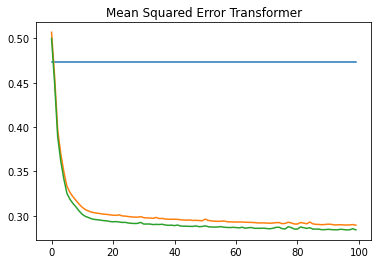

In [201]:
# Show results of the loss function

fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

baseline = [np.mean(losses_train) for i in range(len(train_losses))]

ax.plot(baseline)
ax.plot([np.mean(i) for i in train_losses])
ax.plot([np.mean(i) for i in test_losses])
ax.set_title("Mean Squared Error Transformer")
fig.canvas.draw()

The last basemodel i am going to use is a simple RNN. The final model should also have a better performance than this RNN.

In [218]:
def create_sequece_dataloaders(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one sequence of 30 measures (18 features) and target are the next sequence of 30 
  # measures (18 features)). When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):
    data = np.array(dataset_norm.iloc[i:i+30, 1:])
    target = np.array(dataset_norm.iloc[i+30:i+60, 1:])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=64,
      shuffle=False
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=64,
      shuffle=False
  )

  return loader_train, loader_test

length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




In [204]:
loader_train, loader_test = create_sequece_dataloaders(dataset_norm)

100%|██████████| 63300/63300 [00:24<00:00, 2637.32it/s]


In [219]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.7443890079237128
Standard deviation Loss of baselinemodel:  0.05472206398141798


Test set
Mean Loss of baselinemodel:  0.7505416827972489
Standard deviation Loss of baselinemodel:  0.05128823597546373




# RNN Model

We train before a standard RNN and see which results we can expected with a small and easy solution.
I am using this template (https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb) and make changes using it as a base.

1) torch.nn.RNN (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

Parameters
* input_size – The number of expected features in the input x
* hidden_size – The number of features in the hidden state h
* num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1
* nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'
* bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
* batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
* dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0
* bidirectional – If True, becomes a bidirectional RNN. Default: False

2) torch.nn.Linear (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

Parameters
* in_features – size of each input sample
* out_features – size of each output sample
* bias – If set to False, the layer will not learn an additive bias. Default: True


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, device, batch_first = True, dropout = 0):
        super(RNN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = device

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_dim, num_layers = n_layers, batch_first = batch_first, dropout = dropout)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size).to(self.device)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        out = torch.relu(out)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [ ]:
def train_RNN(model, criterion, optimizer, train_set, test_set):

  epoch_loss_train = []
  epoch_loss_test = []

  # Training Run
  for epoch in range(1, n_epochs + 1):

    print(f'Epoch {epoch}')

    losses_train = []
    losses_test = []

    model.train()

    optimizer.zero_grad() # Clears existing gradients from previous epoch

    print('\nTraining:')
    for i in tqdm(range(len(train_set))):

      input = train_set[i][0]

      target = train_set[i][1]

      output, hidden = model_rnn(input.unsqueeze(0))

      #Compute loss
      loss = criterion(output, target)

      #Backpropagation
      loss.backward()

      #Optimization
      optimizer.step()

    print('\nTest with training set')
    model.eval()
    with torch.no_grad():
      for i in tqdm(range(len(train_set))):
        input = train_set[i][0]
        target = train_set[i][1]

        output, hidden = model(input.unsqueeze(0))

        #Compute loss
        losses_train.append (float(criterion(output, target).item()))

    print('\nTest with test set')
    model.eval()
    with torch.no_grad():
      for i in tqdm(range(len(test_set))):
        input = train_set[i][0]
        target = train_set[i][1]

        output, hidden = model(input.unsqueeze(0))

        #Compute loss
        losses_test.append (float(criterion(output, target).item()))


    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return epoch_loss_train, epoch_loss_test, model

In [ ]:
# Instantiate the model with hyperparameters
model_rnn = RNN(input_size = 18,
                output_size = 18,
                hidden_dim = 36,
                n_layers = 1,
                batch_first = True,
                dropout = 0,
                device = device)

# We'll also set the model to the device that we defined earlier (default is CPU)
model_rnn = model_rnn.to(device)

# Define hyperparameters
n_epochs = 4
lr=0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr)

train_set = training_data_pairs
test_set = testing_data_pairs

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).


In [ ]:
def positional_encoding(seq_len: int, dim_model: int, device):
    
    # Tensor with the positions of every sequence element (0 to seq_len)
    pos = torch.arange(seq_len, dtype=float32, device=device).reshape(1, -1, 1)
    
    # Tensor with the positions of every feature in the sequence (0 to dim_model)
    dim = torch.arange(dim_model, dtype=float32, device=device).reshape(1, 1, -1)

    phase = pos / (1e4 ** (torch.div(dim, dim_model, rounding_mode='floor')))

    position_encoding = torch.where(dim.long() % 2 == 0, sin(phase), cos(phase))

    return position_encoding.to(device)


class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, debug: bool = False, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device
        self.debug = debug

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)
        
    def forward (self, src):
        
        mask = self.generate_square_mask(len(src))
        if self.debug is True:
            print('mask creation: ok')

        src_pos = src + positional_encoding(src.shape[1], src.shape[2], self.device)
        if self.debug is True:
            print('Pos encoder (encoder): ok')

        output = self.encoder (src, mask)
        if self.debug is True:
            print('encoder pass: ok')
        
        output = self.decoder (src_pos, output, mask)
        if self.debug is True:
            print('decoder pass: ok')
        return output

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [ ]:
# Initialize Transformer Model and Optimizer

model = Transformer (num_encoder_layers=3,
                     num_decoder_layers=3,
                     feature_size=18,
                     output_size=18,
                     num_heads=3,
                     device = device,
                     batch_first=False,
                     debug=False)


train_set = training_data_pairs
test_set = testing_data_pairs

print('Setup model Ok')

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

epoch_loss_train = []
epoch_loss_test = []

train_transformer = True

if train_transformer is True:

  # Lists to keep track of the losses
  loss_list_train = []
  loss_list_test = []

  n_epochs = 4

  for e in range(1, n_epochs + 1):
    print('Epoch: ', e)

    print('Training:')
    model.train()
    # Initialize optimizer gradients
    optimizer.zero_grad()

    for i in tqdm(range(len(train_set))):

      input = train_set[i][0]

      target = train_set[i][1]

      net_out = model.forward(input.unsqueeze(0))

      #Compute loss
      loss = criterion(net_out, target.unsqueeze(0))

      #Backpropagation
      loss.backward()

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(range(len(train_set))):
        input = train_set[i][0]
        target = train_set[i][1]

        net_out = model.forward(input.unsqueeze(0))

        #Compute loss
        losses_train.append (float(criterion(net_out, target.unsqueeze(0)).item()))


    print('\nTest with training set')
    losses_test = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(range(len(test_set))):
        input = train_set[i][0]
        target = train_set[i][1]

        net_out = model.forward(input.unsqueeze(0))

        #Compute loss
        losses_test.append (float(criterion(net_out, target.unsqueeze(0)).item()))

    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

Setup model Ok
Setup optimizer Ok
Epoch:  1
Training:


100%|██████████| 56996/56996 [22:57<00:00, 41.39it/s]



Test with training set


100%|██████████| 56996/56996 [05:35<00:00, 169.71it/s]



Test with training set


100%|██████████| 6333/6333 [00:37<00:00, 169.22it/s]



Current Mean loss Train Set:  17.8081452231113

Current Mean loss Test Set:  17.808013503253694


Epoch:  2
Training:


100%|██████████| 56996/56996 [22:41<00:00, 41.87it/s]



Test with training set


100%|██████████| 56996/56996 [05:36<00:00, 169.24it/s]



Test with training set


100%|██████████| 6333/6333 [00:37<00:00, 168.93it/s]



Current Mean loss Train Set:  20.689044967284328

Current Mean loss Test Set:  20.689511593533


Epoch:  3
Training:


100%|██████████| 56996/56996 [22:30<00:00, 42.19it/s]



Test with training set


100%|██████████| 56996/56996 [05:34<00:00, 170.51it/s]



Test with training set


100%|██████████| 6333/6333 [00:36<00:00, 171.82it/s]



Current Mean loss Train Set:  17.399096156414856

Current Mean loss Test Set:  17.37718508319984


Epoch:  4
Training:


100%|██████████| 56996/56996 [22:27<00:00, 42.31it/s]



Test with training set


100%|██████████| 56996/56996 [05:32<00:00, 171.35it/s]



Test with training set


100%|██████████| 6333/6333 [00:36<00:00, 172.01it/s]


Current Mean loss Train Set:  9.250140273476477

Current Mean loss Test Set:  9.267819709392327




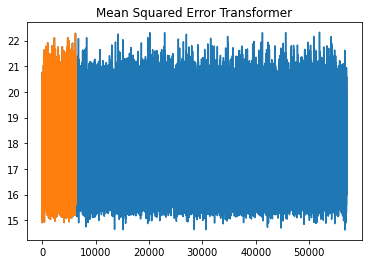

In [ ]:
# Show results of the loss function

fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

ax.plot([np.mean(i) for i in epoch_loss_train])
ax.plot([np.mean(i) for i in epoch_loss_test])
ax.set_title("Mean Squared Error Transformer")
fig.canvas.draw()

Ideas, things to remember, to search, etc...

reconstruction, vergelich mit base line model